In [1]:
import pandas as pd
import datetime
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
from tabulate import tabulate
import datetime as dt

In [2]:
us_confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
us_death_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
timestr = time.strftime("%Y%m%d-%H%M%S")

In [3]:
def get_n_melt_data(data_url, case_type, keys):
    df = pd.read_csv(data_url)
    reshape_df = df.melt(id_vars=keys)
    reshape_df.rename(columns={"variable": "Date", "value": case_type}, inplace=True)
    return reshape_df

def merge_data(confirmed, death):
    new_df = confirmed.join(death["Deaths"])
    new_df = new_df.join(death["Population"])
    return new_df

def fetch_data():
    confirm_df = get_n_melt_data(us_confirmed_cases_url, "Confirmed", ["UID","iso2","iso3","code3","FIPS","Admin2","Province_State","Country_Region","Lat","Long_","Combined_Key"])
    deaths_df = get_n_melt_data(us_death_cases_url, "Deaths", ["UID","iso2","iso3","code3","FIPS","Admin2","Province_State","Country_Region","Lat","Long_","Combined_Key","Population"])
    
    print("Getting and Reshaping Data")
    df = merge_data(confirm_df, deaths_df)
    print("Preview")
    #filename= "covid19_dataset_{}.csv".format(timestr)
    filename= "covid19_dataset_us.csv"
    print("Saving Data as {}".format(filename))
    df.to_csv(filename)
    print("Done")

fetch_data()

Getting and Reshaping Data
Preview
Saving Data as covid19_dataset_us.csv
Done


In [4]:
filename= "covid19_dataset_us.csv"
df = pd.read_csv(filename)
df = df[['Province_State', 'Country_Region', 'Lat', 'Long_', 'Date', 'Confirmed', 'Deaths',"Population"]]
df.head()


,Province_State,Country_Region,Lat,Long_,Date,Confirmed,Deaths,Population
0,American Samoa,US,-14.2710,-170.1320,1/22/20,0,0,55641
1,Guam,US,13.4443,144.7937,1/22/20,0,0,164229
2,Northern Mariana Islands,US,15.0979,145.6739,1/22/20,0,0,55144
3,Puerto Rico,US,18.2208,-66.5901,1/22/20,0,0,2933408
4,Virgin Islands,US,18.3358,-64.8963,1/22/20,0,0,107268


C:\Users\chali\.conda\envs\my_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Max number of cases per country
Province_State              Confirmed    Deaths
------------------------  -----------  --------
New York                        76876      4009
Michigan                         9045       402
Illinois                         8728       209
New Jersey                       7533       263
California                       6936       169
Florida                          4997        51
Louisiana                        4942       185
Pennsylvania                     4272        65
Connecticut                      4136       132
Washington                       3486       230
Massachusetts                    3245        68
Texas                            2146        23
Indiana                          2141        48
Nevada                           1734        54
Arizona                          1495        35
Wisconsin                        1323        49
District of Columbia             1211        24
Missouri                         1203        14
Georgia 

Text(0.5, 1.0, 'Confirmed and Death Cases for each state')

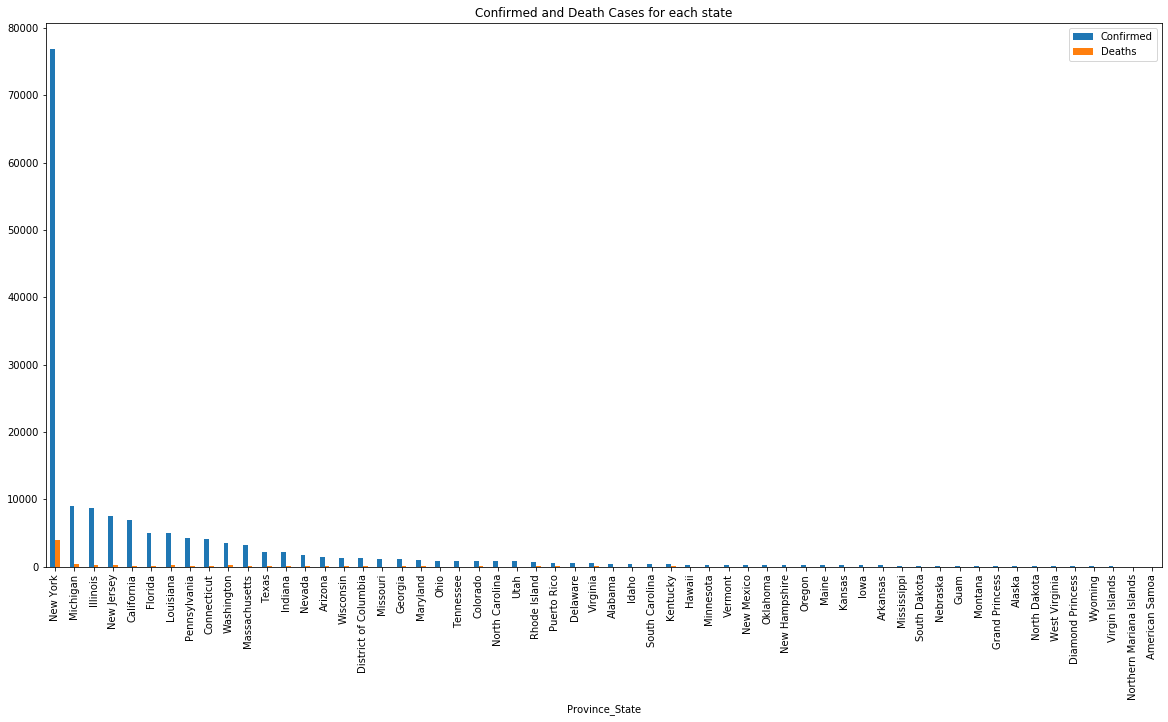

In [5]:
max_cases_per_state = df.groupby(['Province_State'])['Confirmed', 'Deaths'].max()
table_max_cases = max_cases_per_state.sort_values(by=['Confirmed'], ascending=False)
print("Max number of cases per country")
print(tabulate(table_max_cases,headers='keys'))
table_max_cases.plot(kind='bar', figsize=(20,10))
plt.title("Confirmed and Death Cases for each state")



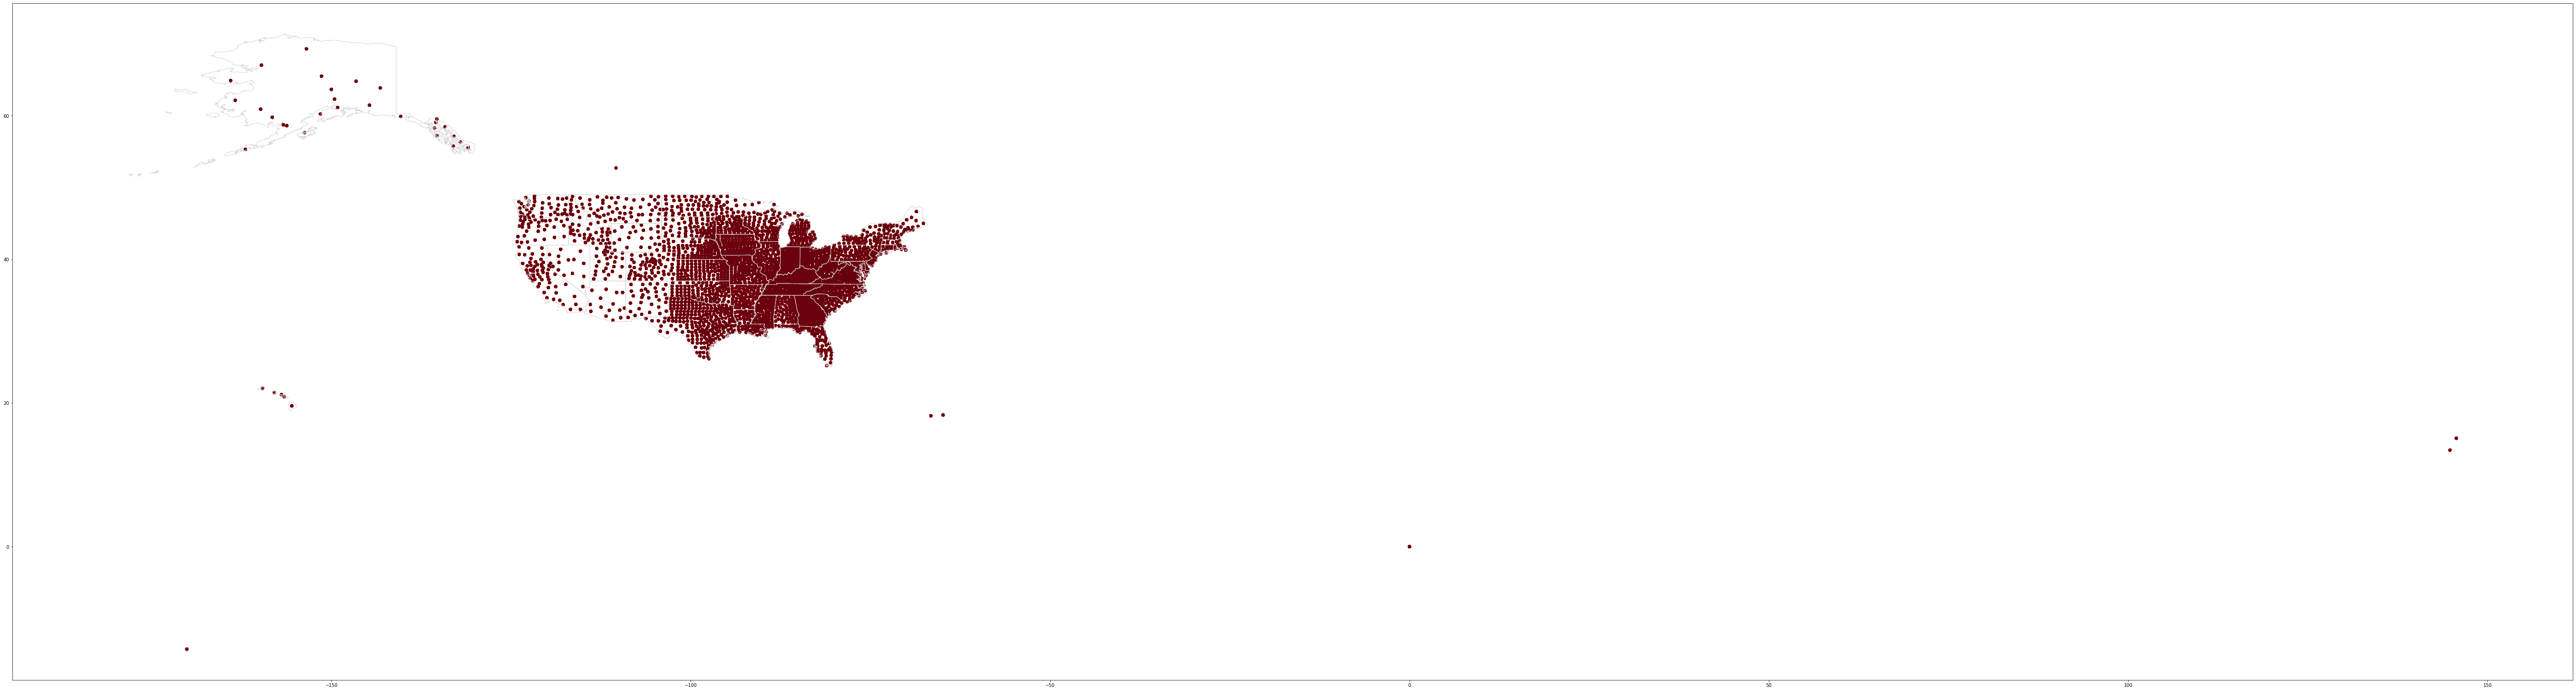

In [6]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Long_'], df['Lat']))
north_america = gpd.read_file("./states/states.shp")
fig,ax = plt.subplots(figsize=(100,50))
gdf.plot(cmap="Reds", ax=ax)
north_america.geometry.boundary.plot(color='lightgrey', edgecolor="white", linewidth=1, ax=ax, figsize=(100, 50))


In [ ]:
df2 = df
df.to_csv("covid19_dataset_us_clean.csv")
df['cases_dates'] =  pd.to_datetime(df2['Date'])

In [ ]:
df2.set_index('cases_dates')[['Confirmed','Deaths']].plot(figsize=(20,10))
plt.title('Cumulative Daily Confirmed, Recovered and Death Cases for US')

In [ ]:
df_by_date = df2.set_index('cases_dates').groupby(['cases_dates']).sum().reset_index(drop=None)
df_by_date[['Confirmed', 'Deaths']].plot(kind='line', figsize=(20,10))
plt.title('Total Confirmed and Death Cases for each day for US')

In [ ]:
df_by_date = df_by_date.set_index('cases_dates')
daily_cases = df_by_date[['Confirmed', 'Deaths']]
diff = daily_cases.diff().fillna(0).plot(kind='line', figsize=(20,10))
plt.title("Daily Confirmed and Death Cases for US")

In [ ]:
louisiana_cases = df[df['Province_State'] == 'Louisiana'].set_index('cases_dates').groupby(['cases_dates']).sum().reset_index(drop=None)
louisiana_cases_asc = louisiana_cases.sort_values(by=['Confirmed'], ascending=False)
print(tabulate(louisiana_cases_asc, headers="keys"))

In [ ]:
louisiana_cases[['Confirmed', 'Deaths']].plot(kind='line', figsize=(20,10))
plt.title('Cumulative Daily Confirmed and Death Cases For Louisiana')

In [ ]:
louisiana_daily_cases = louisiana_cases[['Confirmed', 'Deaths']]
diff = louisiana_daily_cases.diff().fillna(0).plot(kind='line', figsize=(20,10))
plt.title("Daily Confirmed and Death Cases for Louisiana")